In [22]:
import numpy as np
import torch
from torchvision import transforms
import cv2
import matplotlib
import matplotlib.pyplot as plt
from XAI import IntegratedGradients, attribution_mask_processing, GradCAM
from models import VGGNB

### Load model

In [ ]:
model = VGGNB()
model.load_state_dict(torch.load('models\\best_VGGNB.pt', map_location=torch.device('cpu')))
model.eval()

### Define image pre-processing

More information about models pre-processing can be found in ``dataloaders``.

In [24]:
# Define the required transformations for the VGGNB
img_size = 224
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((img_size,img_size)),
            transforms.Normalize(
                mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
        ])

### Load the image

In [25]:
# Load the desired image
path_img = 'Datasets\\Folds\\0\\Test\\ID5_COPE_S00_pain.jpg'
target_class = 1 # 1-Pain / 0-No Pain
image = cv2.imread(path_img) # Load BGR image to VGGFace 
image_RGB = cv2.cvtColor(cv2.resize(image,(img_size,img_size)), cv2.COLOR_BGR2RGB) 
image = image/255 # Normalize to [0-1]
image = np.float32(image)
image = transform(image)

### Create IG and GC object

Instatiate the Integrated Gradients and GradCam, for the GradCAM we are going to use the ``conv5_3`` layer as target.

In [26]:
ig = IntegratedGradients(model)
gradcam = GradCAM(model, model.VGGFace.features.conv5_3)

Generates attribution masks based on provide image and target class.

In [34]:
# Generate the attribution mask
mask_ig = ig.attribution_mask(image, target_class, n_steps=50)
mask_gc = gradcam.attribution_mask(image, target_class)

Text(0.5, 1.0, 'Attribution Mask GC')

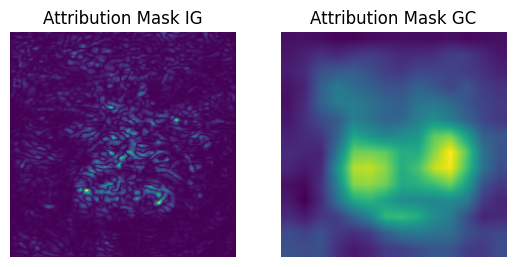

In [42]:
plt.subplot(1,2,1)
plt.imshow(mask_ig)
plt.axis('off')
plt.title('Attribution Mask IG')

plt.subplot(1,2,2)
plt.imshow(mask_gc)
plt.axis('off')
plt.title('Attribution Mask GC')

This is a very poor visualization of the attribution mask. But using the below method we can enhance the visualisation and provide visual understanding of the model's predictions.

### Attribution mask post-processing

Attribution mask post-processing aims to remove redundant information from the original attribution masks, making visualisation and comparisson easier.

There are several parameters that can be tweaked in order to achieve better visualisations on ``attribution_mask_post_processing``.

In [39]:
# Apply post-processing
result_ig, alpha_channel_ig = attribution_mask_processing(mask_ig)
result_cam, alpha_channel_cam = attribution_mask_processing(mask_gc)

### Final visualization

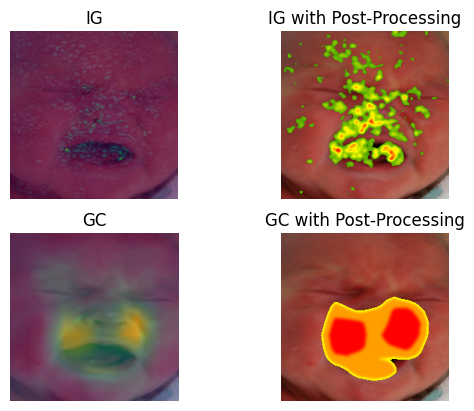

In [40]:
# Define the plot colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

# Plot                                                    
plt.subplot(2,2,1)
plt.title('IG')
plt.imshow(mask_ig)
plt.imshow(image_RGB, alpha=0.5)
plt.axis('off')

plt.subplot(2,2,2)
plt.title('IG with Post-Processing')
plt.imshow(image_RGB)
plt.imshow(result_ig, cmap=cmap, alpha=alpha_channel_ig)
plt.axis('off')

plt.subplot(2,2,3)
plt.title('GC')
plt.imshow(mask_gc)
plt.imshow(image_RGB, alpha=0.5)
plt.axis('off')

plt.subplot(2,2,4)
plt.title('GC with Post-Processing')
plt.imshow(image_RGB)
plt.imshow(result_cam, cmap=cmap, alpha=alpha_channel_cam)
plt.axis('off')

plt.show()